In [1]:
import pandas as pd

from datetime import datetime
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
from torch.autograd import Variable 
import argparse

import seaborn as sns 
import matplotlib.pyplot as plt

#from collections import Counter
import torch.nn.utils as torch_utils

In [2]:
# 로그 선택 및 경로설정
fName='BPI17'

savePath = './Result/'
modelName = 'RTPrediction_'
modelVer = 'v1'

In [3]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1, num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
        # define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(self.hidden_dim, self.hidden_dim, self.num_layers, batch_first=True)
        # define the output layer
        self.bn = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        
    def init_hidden(self):
        # initialize hidden states
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).type(dtype),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).type(dtype))
    
    def forward(self, input):
        input = input.type(dtype)
        #print('input shape',input.shape)
        lstm_out, self.hidden = self.lstm(input)
        #print('lstm out', lstm_out.shape)
        lstm_out = lstm_out.reshape(-1, lstm_out.shape[2])
        #print('shaped',lstm_out.shape)
        lstm_out = self.bn(lstm_out) # 배치정규화
        #print('out bn',lstm_out.shape)
        lstm_out = lstm_out.reshape(batch_size, int(lstm_out.shape[0]/batch_size), lstm_out.shape[1])
        lstm_out, self.hidden = self.lstm2(lstm_out)  
        lstm_out = lstm_out.reshape(-1, lstm_out.shape[2])
        lstm_out = self.bn(lstm_out)
        y_pred = self.fc(lstm_out)

        y_pred = y_pred.reshape(self.batch_size, -1)
        return y_pred[:,-1], self.hidden
        
        

In [4]:
def buildOHE(index,n): # 원핫 인코딩
    L=[0]*n
    L[index]=1
    return L

def buildOHE2(index,arr): # 집약패턴 인코딩(이전 정보 반영)
    arr[index]=1
    return arr

In [5]:
def load_dataset(name):

    if name=="BPI12":
        return _load_dataset_name("FinalData/bpi_12_w.csv")
    elif name=="BPI15":
        return _load_dataset_name("FinalData/BPI15_1_Final_Nava.csv")
    elif name=="BPI17":
        return _load_dataset_name("FinalData/BPI2017_M3000_Final_Nava.csv")
    elif name=='helpdsk':
        return _load_dataset_name("FinalData/helpdesk_N.csv")
    elif name=='Credit':
        return _load_dataset_name("FinalData/Credit_Final_Nava.csv")
    elif name=='Invoice':
        return _load_dataset_name("FinalData/Invoice_Final_Nava.csv")

    
def _load_dataset_name(fName):
    dataframe = pd.read_csv(fName, header=0)
    dataframe = dataframe.replace(r's+', 'empty', regex=True)
    dataframe = dataframe.fillna(0)
    dataset=dataframe.values
    
    global gridNum
    
    values = []
    for i in range(dataset.shape[1]):
        values.append(len(np.unique(dataset[:, i])) )
    print(values)

    elems_per_fold = int(values[0] / 5)
    datasetTR = dataset[dataset[:,0]<4*elems_per_fold]
    datasetTS = dataset[dataset[:,0]>=4*elems_per_fold]       
    print('TrainLen : ',len(datasetTR)," TestLen : ",len(datasetTS))
    
    return generate_set(datasetTR, values, dataframe.dtypes), generate_set(datasetTS, values, dataframe.dtypes)    
    
    
def generate_set(dataset, values, dfDtype):
    data=[]
    newdataset=[]
    temptarget=[] 
    aggregation=[]
    
    actOccurCnt=[0]*(values[1]+1)
    actOccurTime=[0]*(values[1]+1)
    loopStartPoint=0

    caseArr=[]
    caseX=''
        
    #analyze first dataset line
    caseID=dataset[0][0]
    event=dataset[0][1]
    
    # 트레이스 시작 시간, 이전 이벤트 타임스탬프, 해당 이벤트 타임스탬프 날짜의 자정, 2,3번의 차이
    starttime=datetime.fromtimestamp(time.mktime(time.strptime(dataset[0][2], "%Y-%m-%d %H:%M:%S")))
    lastevtime=starttime
    #t=time.strptime(dataset[0][2], "%Y-%m-%d %H:%M:%S")
    midnight = starttime.replace(hour=0, minute=0, second=0, microsecond=0)
    timesincemidnight = (starttime - midnight).total_seconds()
    
    # 초기화 겸 첫 이벤트 값 처리
    n=1
    temptarget.append(starttime) ############# 이부분이 왜 starttime이 들어가는지 까먹었다
    a=[0,0,timesincemidnight,starttime.weekday(),0] # 첫 이벤트는 경과시간이 0이므로 0으로 초기화
    #[경과시간,이전이벤트로부터 경과시간, 자정으로부터경과시간, 요일, 반복실행으로부터경과시간]
    idNum = int(dataset[0][1][1:])
    aggregation=(buildOHE(idNum, values[1]+1)) ##0427##1
    actOccurCnt[idNum]+=1 # 액티비티의 실행 횟수 카운트
    actOccurTime[idNum]=starttime # 해당 액티비티의 첫 등장 시간 저장


    field = 3
    b=[]
    for i in dataset[0][3:]:
        if np.issubdtype(dfDtype[field], np.number):
            a.append(i)
        else:
            b.extend(buildOHE(int(i[1:]), values[field]+1))
        field+=1
    
    # 벡터에서 어느 파트까지가 스케일링이고 아이디고 인코딩인지 표시
    vectorPoint=[len(a),len(aggregation),len(b)]
    
    a.extend(aggregation)
    a.extend(b)
    newdataset.append(a)

        
    for line in dataset[1:,:]:
        case=line[0]
        if case==caseID: #이전 이벤트랑 같은 트레이스 소속일 경우
            #t = time.strptime(line[2], "%Y-%m-%d %H:%M:%S")
            nowtime=datetime.fromtimestamp(time.mktime(time.strptime(line[2], "%Y-%m-%d %H:%M:%S")))
            midnight = nowtime.replace(hour=0, minute=0, second=0, microsecond=0)
            temptarget.append(datetime.fromtimestamp(time.mktime(time.strptime(line[2], "%Y-%m-%d %H:%M:%S"))))  ##############
            
            a=[(nowtime- starttime).total_seconds()]
            a.append((nowtime- lastevtime).total_seconds())
            a.append((nowtime - midnight).total_seconds())   
            a.append(nowtime.weekday())
            
            idNum = int(line[1][1:])
            aggregation = (buildOHE2(idNum, aggregation)) ##0427##
            
            actOccurCnt[idNum]+=1 # 액티비티의 실행 횟수 카운트
            if actOccurCnt[idNum]==1: # 해당 액티비티가 처음 등장했을 경우, 실행시간을 기록
                actOccurTime[idNum]=nowtime 
            if actOccurCnt[idNum]>1: # 해당 액티비티가 반복 실행된 액티비티일 경우
                if loopStartPoint==0: # 반복적 제어흐름의 첫 반복일 경우
                    loopStartPoint = actOccurTime[idNum] # 반복적 제어흐름의 시작시간 저장
                a.append((nowtime-loopStartPoint).total_seconds()) # 반복적 제어흐름 시작으로부터의 경과시간 계산 및 특징 추가
            else:
                loopStartPoint=0 # 반복적 제어흐름이 아닐경우 해당 변수 0으로 초기화
                a.append(0) # 반복적 제어흐름으로부터의 경과시간 값으로 0 삽입
            
            field=3
            b=[] # 스케일링 값은 a에 인코딩은 b에 그리고 나중에 a로 통합
            for i in line[3:]:
                if np.issubdtype(dfDtype[field], np.number):
                    a.append(i)
                else:
                    b.extend(buildOHE(int(line[field][1:]), values[field]+1))
                field+=1
                
            a.extend(aggregation)
            a.extend(b)
            newdataset.append(a)
            n+=1
            lastevtime = nowtime # 마지막 실행 이벤트 갱신
            finishtime = nowtime
            caseX=line[0]
                
            
        else: # 새로운 트레이스가 시작될때
            caseID=case
            for i in range(1,len(newdataset)):
                data.append(newdataset[:i+1])
                caseArr.append(caseX)
                
            actOccurCnt=[0]*(values[1]+1)
            actOccurTime=[0]*(values[1]+1)
            newdataset=[]
            starttime = datetime.fromtimestamp(time.mktime(time.strptime(line[2], "%Y-%m-%d %H:%M:%S")))
            
            #t = time.strptime(line[2], "%Y-%m-%d %H:%M:%S")
            midnight = starttime.replace(hour=0, minute=0, second=0, microsecond=0)
            timesincemidnight = (starttime - midnight).total_seconds()
            
            a=[0,0,timesincemidnight, starttime.weekday(),0]
            #[경과시간,이전이벤트로부터 경과시간, 자정으로부터경과시간, 요일, 반복실행으로부터경과시간]
            idNum = int(line[1][1:])
            aggregation=(buildOHE(int(line[1][1:]), values[1]+1))
            
            actOccurCnt[idNum]+=1 # 액티비티의 실행 횟수 카운트
            actOccurTime[idNum]=starttime # 해당 액티비티의 첫 등장 시간 저장


            field=3
            b=[]
            for i in line[3:]:
                if np.issubdtype(dfDtype[field], np.number):
                    a.append(i)
                else:
                    b.extend(buildOHE(int(line[field][1:]), values[field]+1))
                field+=1
            a.extend(aggregation)
            a.extend(b)
            newdataset.append(a)
                
            # 그동안 종료시간을 담아오다가 해당 트레이스 길이만큼 거꾸로 가면서 잔여시간 계산
            for i in range(n):
                temptarget[-(i+1)]=(finishtime-temptarget[-(i+1)]).total_seconds() 
            temptarget.pop() #마지막 종료된 상태는 예측에서 제외
            temptarget.append(starttime)
            
            lastevtime = starttime
            finishtime = starttime
            n = 1
        
    # 마지막 트레이스 처리파트
    for i in range(1,len(newdataset)):
        data.append(newdataset[:i+1])
        caseArr.append(caseX) ###0504
    
    for i in range(n):
        temptarget[-(i + 1)] = (finishtime - temptarget[-(i + 1)]).total_seconds()
    temptarget.pop()


    print(len(data))
    print("Generated dataset with n_samples:", len(temptarget))
    assert(len(temptarget)== len(data))
    print(vectorPoint)
    return data, temptarget, vectorPoint, caseArr

In [6]:
(train_x_origin, train_y_origin, vectorP, train_case),(test_x_origin, test_y_origin, vectorP, test_case)= load_dataset(fName)
#[스케일링파트, 아이디 인코딩 파트, 기타 속성 인코딩 파트] 각 파트의 길이

[3000, 24, 31907]
TrainLen :  38020  TestLen :  8648
35621
Generated dataset with n_samples: 35621
[5, 25, 0]
8047
Generated dataset with n_samples: 8047
[5, 25, 0]


In [7]:
def vecToStr(vec):
    re=''
    for x in vec:
        re += str(x)
    return re

In [8]:
#집약패턴에 따른 평균 잔여시간 계산 파트

CRTdic={}
CRTvalue={}
totalRT=[] #모든 인스턴스(부분포함)의 잔여시간을 담을 리스트

preLen=99
for x,y in zip(train_x_origin,train_y_origin):
    if preLen>len(x): #인스턴스의 첫 이벤트일 경우
        cid = vecToStr(x[0][vectorP[0]:vectorP[0]+vectorP[1]])
        try:
            CRTdic[cid][0]+=y
            CRTdic[cid][1]+=1          
        except:
            CRTdic[cid]=[y,1] #총 잔여시간, 개수
            
    cid = vecToStr(x[-1][vectorP[0]:vectorP[0]+vectorP[1]])
    try:
        CRTdic[cid][0]+=y
        CRTdic[cid][1]+=1  
    except:
        CRTdic[cid]=[y,1] #총 잔여시간, 개수
    
    preLen=len(x)
    totalRT.append(y)

#잔여시간에 대한 최대 최소 및 사분위수 값 계산
totalQ = [np.quantile(totalRT,0.0),np.quantile(totalRT,0.25),np.quantile(totalRT,0.50),
                 np.quantile(totalRT,0.75),np.quantile(totalRT,1.0),np.mean(totalRT)]
#Min-Max 정규화 적용
for x in CRTdic:
    CRTvalue[x]=(totalQ[4]-int(CRTdic[x][0]/CRTdic[x][1]))/(totalQ[4]-totalQ[0])
#print(CRTvalue)

In [9]:
# 액티비티별 정규화 파트
# 액티비티는 업무수행의 기본 단위로 액티비티별로 다른 속성과 인과관계를 가지므로 개별 정규화 수행
idSpoint=vectorP[0]
idEpoint=vectorP[1]+vectorP[0]

tmpArr = [[] for i in range(vectorP[0])]
tmpArrY = [[] for i in range(vectorP[0])]

for ep in range(vectorP[0]):# 벡터 한칸씩 처리
    saveArr=[[] for i in range(vectorP[1])]
    for x in train_x_origin:  # 아이디별로 값 수집
        saveArr[x[-1][idSpoint:idEpoint].index(1)].append(x[-1][ep])
        saveArr[0].append(x[-1][ep])
            
    pointArr=[[]]
    for x in saveArr[1:]: # 최대최소 및 사분위 값 계산
        try:
            pointArr.append([np.quantile(x,0.0),np.quantile(x,0.25),np.quantile(x,0.50),np.quantile(x,0.75),np.quantile(x,1.0),np.mean(x), np.std(x)])
        except: # 처음 등장하는 이벤트의 경우 전체에대한 최대최소 값으로 정규화 수행
            pointArr.append([np.quantile(saveArr[0],0.0),np.quantile(saveArr[0],0.25),np.quantile(saveArr[0],0.50),np.quantile(saveArr[0],0.75),np.quantile(saveArr[0],1.0),np.mean(saveArr[0]), np.std(saveArr[0])])        
        

    for xi, x in enumerate(train_x_origin):
        for xxi ,xx in enumerate(x): # 이벤트 하나씩 처리
            idNum=xx[idSpoint:idEpoint].index(1)
            if not pointArr[idNum][4]==pointArr[idNum][0]: # 모든 값이 0 으로 되어있을 경우 또는 같은 값으로 이루어질경우
                tmpArr[ep].append((xx[ep]-pointArr[idNum][0])/(pointArr[idNum][4]-pointArr[idNum][0]))
            else:
                tmpArr[ep].append(0)
                
    for xi, x in enumerate(test_x_origin):
        for xxi ,xx in enumerate(x): # 이벤트 하나씩 처리
            idNum=xx[idSpoint:idEpoint].index(1)
            if not pointArr[idNum][4]==pointArr[idNum][0]: # 모든 값이 0 으로 되어있을 경우 또는 같은 값으로 이루어질경우
                tmpArrY[ep].append((xx[ep]-pointArr[idNum][0])/(pointArr[idNum][4]-pointArr[idNum][0]))
            else:
                tmpArrY[ep].append(0)
                
i=0
for xi, x in enumerate(train_x_origin):
    for xxi, xx in enumerate(x):
        tmp=[]
        for j in range(len(tmpArr)):
            tmp.append(tmpArr[j][i])
        train_x_origin[xi][xxi][:vectorP[0]]=tmp
        i+=1
i=0       
for xi, x in enumerate(test_x_origin):
    for xxi, xx in enumerate(x):
        tmp=[]
        for j in range(len(tmpArrY)):
            tmp.append(tmpArrY[j][i])
        test_x_origin[xi][xxi][:vectorP[0]]=tmp
        i+=1

In [10]:
# 목표값의 단위를 day로 변경
# 타 논문과 성능 비교를 위해 동일한 단위로 변경
train_y_origin = [y1/(3600*24) for y1 in train_y_origin]
test_y_origin = [y1/(3600*24) for y1 in test_y_origin]

In [11]:
# 입력벡터 패딩 (공백을 전방에 배치)
maxTraceLen = len(max(train_x_origin,key=len))
dicLen = len(train_x_origin[0][0])
dumyPadding = [0]*dicLen

# 실제값과 패딩값의 구분 마스크
train_mask=[]
test_mask=[]

changedArr = train_x_origin
for i in range(len(changedArr)):
    if len(changedArr[i]) < maxTraceLen:
        train_mask.append(len(changedArr[i]))
        for x in range(maxTraceLen-len(changedArr[i])):
            changedArr[i].insert(0,dumyPadding)
    elif len(changedArr[i]) > maxTraceLen:
        train_mask.append(maxTraceLen)
        changedArr[i] = changedArr[i][:maxTraceLen]
    else:
        train_mask.append(maxTraceLen)       
train_x_origin = changedArr

changedArr = test_x_origin
for i in range(len(changedArr)):
    if len(changedArr[i]) < maxTraceLen:
        test_mask.append(len(changedArr[i]))
        for x in range(maxTraceLen-len(changedArr[i])):
            changedArr[i].insert(0,dumyPadding)
    elif len(changedArr[i]) > maxTraceLen:
        test_mask.append(maxTraceLen)
        changedArr[i] = changedArr[i][:maxTraceLen]
    else:
        test_mask.append(maxTraceLen)
test_x_origin = changedArr

In [12]:
train_x=train_x_origin
train_y=train_y_origin

test_x=test_x_origin
test_y=test_y_origin

In [13]:
# 학습데이터셋의 1/8을 검증셋으로 사용 (총 학습70, 검증10, 테스트20)
Valkey = int(len(train_x)/10*8)+1
valid_x = train_x[Valkey:]
valid_y = train_y[Valkey:]
train_x = train_x[:Valkey]
train_y = train_y[:Valkey]

In [14]:
# 모델 파라미터 설정 및 모델생성

n_epochs = 300
num_layers = 1
batch_size=1000
lr=0.0001

is_cuda = torch.cuda.is_available()
dict_size = len(train_x[0][0])
hidden_dim = vectorP[1]*2
#print(dict_size)
#print(hidden_dim)

model = LSTM(dict_size, hidden_dim, batch_size=batch_size, output_dim=1, num_layers=num_layers)
if is_cuda : model = model.cuda()
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.float

criterion = nn.L1Loss() # MAE
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [15]:
minLoss=999
max_grad_norm=5

best_realV,best_predV=[],[]
best_epoch=0

train_loss=[]
valid_loss=[]

bestMAE=[999,0]

for epoch in range(1, n_epochs + 1):
    model.train()
    lossSum =0
    lossCnt =0
    for i in range(0,len(train_x),batch_size):
        if i+batch_size > len(train_x): break
        else:
            x = torch.tensor(train_x[i:i+batch_size])
            y = torch.tensor(train_y[i:i+batch_size])
            m = train_mask[i:i+batch_size]
         
            x = Variable(x)
            y = Variable(y)

            if is_cuda: x=x.cuda(); y=y.cuda()
            optimizer.zero_grad() # Clears existing gradients from previous epoch
            output, hidden = model(x.float())
            
            output.type(dtype)
            
            loss = criterion(output, y.view(-1).float())    #train       
            loss.backward(retain_graph=True) # Does backpropagation and calculates gradients
            torch_utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step() # Updates the weights accordingly    
            lossSum += loss.item()
            lossCnt += 1

    train_loss.append(lossSum/lossCnt)     
    print('[[{}/{}]]\ttraining : '.format(epoch,n_epochs),round(lossSum/lossCnt,4), end='\t')
    
    model.eval()
    lossSum =0
    lossCnt =0
    realV=[]
    predV=[]
    for i in range(0,len(valid_x),batch_size):
        if i+batch_size > len(valid_x): break
        else:
            x = torch.tensor(valid_x[i:i+batch_size])
            y = torch.tensor(valid_y[i:i+batch_size])
            m = test_mask[i:i+batch_size]
                
            x = Variable(x)
            y = Variable(y)

            if is_cuda: x=x.cuda(); y=y.cuda()
            output, hidden = model(x.float())   
            loss = criterion(output, y.view(-1).float())    #train   
            
            realV+=y.view(-1).tolist()
            predV+=output.view(-1).tolist()
           
            lossSum += loss.item()
            lossCnt += 1
    
    

    if bestMAE[0]>lossSum/lossCnt:
        bestMAE[0]=lossSum/lossCnt
        bestMAE[1]=epoch
        
    print(' // validation : ',round(lossSum/lossCnt,4), end='\t')    
    valid_loss.append(lossSum/lossCnt)
    
    if minLoss>(lossSum/lossCnt):
        print('****',str(epoch),'****')
        torch.save(model.state_dict(), savePath+modelName+fName+'_'+modelVer+".pth")
        best_realV=realV
        best_predV=predV
        best_epoch=epoch
        minLoss=lossSum/lossCnt
    else:
        print('')

[[1/300]]	training :  14.9242	 // validation :  12.6714	**** 1 ****
[[2/300]]	training :  13.4403	 // validation :  11.5691	**** 2 ****
[[3/300]]	training :  12.3428	 // validation :  10.877	**** 3 ****
[[4/300]]	training :  11.6548	 // validation :  10.383	**** 4 ****
[[5/300]]	training :  11.2208	 // validation :  10.0644	**** 5 ****
[[6/300]]	training :  10.9217	 // validation :  9.8332	**** 6 ****
[[7/300]]	training :  10.697	 // validation :  9.66	**** 7 ****
[[8/300]]	training :  10.5175	 // validation :  9.5219	**** 8 ****
[[9/300]]	training :  10.3674	 // validation :  9.4162	**** 9 ****
[[10/300]]	training :  10.2376	 // validation :  9.3253	**** 10 ****
[[11/300]]	training :  10.1235	 // validation :  9.2455	**** 11 ****
[[12/300]]	training :  10.0227	 // validation :  9.1764	**** 12 ****
[[13/300]]	training :  9.9331	 // validation :  9.1147	**** 13 ****
[[14/300]]	training :  9.8516	 // validation :  9.0648	**** 14 ****
[[15/300]]	training :  9.7768	 // validation :  9.0131

[[122/300]]	training :  8.2985	 // validation :  7.8874	
[[123/300]]	training :  8.2956	 // validation :  7.8866	
[[124/300]]	training :  8.2921	 // validation :  7.8929	
[[125/300]]	training :  8.2891	 // validation :  7.8921	
[[126/300]]	training :  8.2866	 // validation :  7.8898	
[[127/300]]	training :  8.2847	 // validation :  7.886	
[[128/300]]	training :  8.2826	 // validation :  7.8821	**** 128 ****
[[129/300]]	training :  8.2788	 // validation :  7.8826	
[[130/300]]	training :  8.2749	 // validation :  7.891	
[[131/300]]	training :  8.2712	 // validation :  7.8919	
[[132/300]]	training :  8.2689	 // validation :  7.8881	
[[133/300]]	training :  8.267	 // validation :  7.8874	
[[134/300]]	training :  8.2648	 // validation :  7.8856	
[[135/300]]	training :  8.2615	 // validation :  7.8825	
[[136/300]]	training :  8.2575	 // validation :  7.8915	
[[137/300]]	training :  8.2543	 // validation :  7.8939	
[[138/300]]	training :  8.251	 // validation :  7.8929	
[[139/300]]	training :

[[266/300]]	training :  7.9406	 // validation :  8.6783	
[[267/300]]	training :  7.9328	 // validation :  8.7152	
[[268/300]]	training :  7.9357	 // validation :  8.7234	
[[269/300]]	training :  7.9336	 // validation :  8.7189	
[[270/300]]	training :  7.9294	 // validation :  8.7302	
[[271/300]]	training :  7.9294	 // validation :  8.7127	
[[272/300]]	training :  7.9262	 // validation :  8.7262	
[[273/300]]	training :  7.9224	 // validation :  8.7039	
[[274/300]]	training :  7.9217	 // validation :  8.7302	
[[275/300]]	training :  7.9181	 // validation :  8.7364	
[[276/300]]	training :  7.9176	 // validation :  8.7706	
[[277/300]]	training :  7.9164	 // validation :  8.7749	
[[278/300]]	training :  7.9132	 // validation :  8.757	
[[279/300]]	training :  7.9195	 // validation :  8.7916	
[[280/300]]	training :  7.9282	 // validation :  8.7595	
[[281/300]]	training :  7.9044	 // validation :  8.7925	
[[282/300]]	training :  7.9001	 // validation :  8.8202	
[[283/300]]	training :  7.8979	 

BPI17
learning Rate :  0.0001
layer :  1
hidden_dim :  50
Train Loss :  7.882141998835972


<function matplotlib.pyplot.show(*args, **kw)>

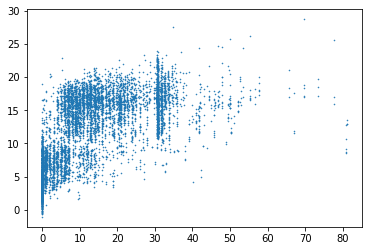

In [16]:
# 학습 결과 검증 그래프
print(fName)
print('learning Rate : ',lr)
print('layer : ',num_layers)
print('hidden_dim : ',hidden_dim)

print('Train Loss : ',bestMAE[0])
plt.scatter(best_realV, best_predV,s=0.3)
plt.show

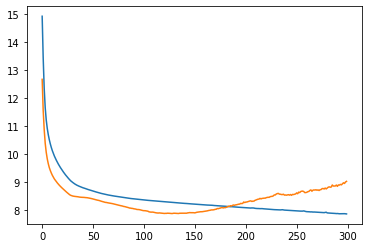

In [17]:
# 반복학습에 따른 오차 선그래프
plt.plot(train_loss)
plt.plot(valid_loss)
plt.show()

In [18]:
model.load_state_dict(torch.load(savePath+modelName+fName+'_'+modelVer+".pth"))

minLoss=999
model.eval()
lossSum, lossCnt = 0, 0
realV, predV, maskV, caseV=[],[],[],[]

for i in range(0,len(test_x),batch_size):
    if i+batch_size > len(test_x): break
    else:
        x = torch.tensor(test_x[i:i+batch_size])
        y = torch.tensor(test_y[i:i+batch_size])
        m = test_mask[i:i+batch_size]
        cid = test_case[i:i+batch_size]
                
        x = Variable(x)
        y = Variable(y)

        if is_cuda: x=x.cuda(); y=y.cuda()
        output, hidden = model(x.float())   
        loss = criterion(output, y.view(-1).float())    #train   
            
        realV+=y.view(-1).tolist()
        predV+=output.view(-1).tolist()
        maskV+=m
        caseV+=cid
           
        lossSum += loss.item()
        lossCnt += 1
        
print('test : ',round(lossSum/lossCnt,4))

test :  7.3847


BPI17
learning Rate :  0.0001
layer :  1
hidden_dim :  50
test :  7.3847


<function matplotlib.pyplot.show(*args, **kw)>

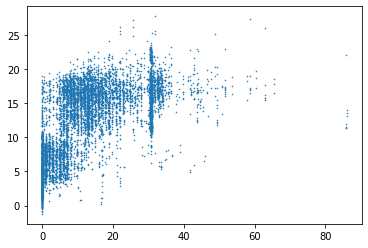

In [19]:
print(fName)
print('learning Rate : ',lr)
print('layer : ',num_layers)
print('hidden_dim : ',hidden_dim)
print('test : ',round(lossSum/lossCnt,4))

plt.scatter(realV, predV,s=0.3)
plt.show

In [20]:
# 인스턴스 진행정도별 오차 측정
prefixResult=[0]*maxTraceLen
prefixCount=[0]*maxTraceLen
for rv,pv,mv in zip(realV,predV,maskV):
    if mv>=maxTraceLen:
        prefixResult[maxTraceLen-1]+=abs(rv-pv)
        prefixCount[maxTraceLen-1]+=1
    else:
        prefixResult[mv]+=abs(rv-pv)
        prefixCount[mv]+=1
totalMae=sum(prefixResult)/sum(prefixCount)
print('totalMAE : ',totalMae,' cnt : ',sum(prefixCount))
    
for i in range(maxTraceLen):
    if prefixCount[i]==0:
        print(str(i), '\t : ' ,prefixResult[i])
    else:     
        print(str(i), '\t : ' ,prefixResult[i]/prefixCount[i],' cnt : ',prefixCount[i])
        prefixResult[i]=prefixResult[i]/prefixCount[i]


totalMAE :  7.384696269956382  cnt :  8000
0 	 :  0
1 	 :  0
2 	 :  9.315512243502305  cnt :  597
3 	 :  9.134702560365499  cnt :  597
4 	 :  9.025288564723978  cnt :  597
5 	 :  9.194079179748881  cnt :  597
6 	 :  9.118449383635632  cnt :  597
7 	 :  9.16403291031595  cnt :  597
8 	 :  8.986942349450656  cnt :  597
9 	 :  7.852044875743826  cnt :  595
10 	 :  6.544412012364068  cnt :  584
11 	 :  5.74987720642309  cnt :  499
12 	 :  4.698698202937913  cnt :  425
13 	 :  4.455171919630526  cnt :  387
14 	 :  4.512946664028357  cnt :  318
15 	 :  4.364918277231177  cnt :  230
16 	 :  4.279304142104003  cnt :  182
17 	 :  4.514544309488351  cnt :  130
18 	 :  4.599128635861814  cnt :  102
19 	 :  4.757016443525208  cnt :  80
20 	 :  4.796383542564936  cnt :  61
21 	 :  4.877284867430622  cnt :  48
22 	 :  3.712547786177732  cnt :  41
23 	 :  3.880629943885045  cnt :  30
24 	 :  4.071799975766308  cnt :  22
25 	 :  3.2143672609871086  cnt :  22
26 	 :  3.5375171090875352  cnt :  14
27 	 